In [1]:

import pandas as pd
from google.colab import files
import io

# Upload the file
uploaded = files.upload()

# Get the name of the uploaded file
file_path = next(iter(uploaded))  # This gets the first key in the uploaded dictionary, which is the file name

# Load the CSV file into a DataFrame
data = pd.read_csv(io.BytesIO(uploaded[file_path]))

# Display the first few rows of the DataFrame
print(data)

Saving Telco-Customer-Churn.csv to Telco-Customer-Churn.csv
      customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0     7590-VHVEG  Female              0     Yes         No       1   
1     5575-GNVDE    Male              0      No         No      34   
2     3668-QPYBK    Male              0      No         No       2   
3     7795-CFOCW    Male              0      No         No      45   
4     9237-HQITU  Female              0      No         No       2   
...          ...     ...            ...     ...        ...     ...   
7038  6840-RESVB    Male              0     Yes        Yes      24   
7039  2234-XADUH  Female              0     Yes        Yes      72   
7040  4801-JZAZL  Female              0     Yes        Yes      11   
7041  8361-LTMKD    Male              1     Yes         No       4   
7042  3186-AJIEK    Male              0      No         No      66   

     PhoneService     MultipleLines InternetService OnlineSecurity  ...  \
0              No  No ph

In [2]:
# Display the first few rows
print(data.head())

# Summary statistics
print(data.describe())

# Data types and missing values
print(data.info())


   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Handle missing values in 'TotalCharges' column (convert to numeric and fill NaNs)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'].fillna(data['TotalCharges'].mean(), inplace=True)

# Encode categorical variables
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    if column != 'customerID':
        label_encoders[column] = LabelEncoder()
        data[column] = label_encoders[column].fit_transform(data[column])

# Drop 'customerID' as it is not useful for prediction
data.drop('customerID', axis=1, inplace=True)

# Split features and target
X = data.drop('Churn', axis=1)
y = data['Churn']

# Scale numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# XGBoost
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)


SVC()

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1

# Evaluate each model
lr_results = evaluate_model(lr_model, X_test, y_test)
rf_results = evaluate_model(rf_model, X_test, y_test)
xgb_results = evaluate_model(xgb_model, X_test, y_test)
svm_results = evaluate_model(svm_model, X_test, y_test)

print(f"Logistic Regression: {lr_results}")
print(f"Random Forest: {rf_results}")
print(f"XGBoost: {xgb_results}")
print(f"SVM: {svm_results}")


Logistic Regression: (0.8161816891412349, 0.678125, 0.5817694369973191, 0.6262626262626263)
Random Forest: (0.7927608232789212, 0.6472727272727272, 0.4772117962466488, 0.5493827160493826)
XGBoost: (0.7821149751596878, 0.6078431372549019, 0.49865951742627346, 0.5478645066273932)
SVM: (0.8069552874378992, 0.684981684981685, 0.5013404825737265, 0.5789473684210527)


In [7]:
from sklearn.ensemble import VotingClassifier

# Combine models
ensemble_model = VotingClassifier(estimators=[
    ('lr', lr_model),
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('svm', svm_model)], voting='hard')

ensemble_model.fit(X_train, y_train)
ensemble_results = evaluate_model(ensemble_model, X_test, y_test)

print(f"Ensemble Model: {ensemble_results}")


Ensemble Model: (0.8062455642299503, 0.7100840336134454, 0.45308310991957107, 0.5531914893617021)


In [8]:
# Feature importance from Random Forest
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)

print(feature_importance_df)

# Recommendations based on feature importance
top_features = feature_importance_df.head(10)
print(f"Top features contributing to churn: {top_features['feature'].values}")


             feature  importance
18      TotalCharges    0.192685
17    MonthlyCharges    0.179303
4             tenure    0.161403
14          Contract    0.067829
16     PaymentMethod    0.051376
8     OnlineSecurity    0.051337
11       TechSupport    0.041792
0             gender    0.027366
15  PaperlessBilling    0.026984
7    InternetService    0.026852
9       OnlineBackup    0.026221
2            Partner    0.023697
6      MultipleLines    0.022608
10  DeviceProtection    0.021454
1      SeniorCitizen    0.020537
3         Dependents    0.018998
13   StreamingMovies    0.017741
12       StreamingTV    0.016756
5       PhoneService    0.005061
Top features contributing to churn: ['TotalCharges' 'MonthlyCharges' 'tenure' 'Contract' 'PaymentMethod'
 'OnlineSecurity' 'TechSupport' 'gender' 'PaperlessBilling'
 'InternetService']


In [ ]:
**Actionable Insights:**
- Focus on improving service quality for features identified as top contributors to churn.
- Develop targeted retention strategies for customers identified at risk of churning.

**Deployment:**
- Save the trained model and deploy it in the production environment for real-time churn prediction.
- Continuously monitor and update the model with new data to maintain accuracy.


In [9]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Train models on resampled data
rf_model.fit(X_resampled, y_resampled)
rf_results_resampled = evaluate_model(rf_model, X_test, y_test)
print(f"Random Forest with SMOTE: {rf_results_resampled}")


Random Forest with SMOTE: (0.7828246983676366, 0.5893333333333334, 0.5924932975871313, 0.5909090909090909)


In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf_model = grid_search.best_estimator_

# Evaluate the best model
best_rf_results = evaluate_model(best_rf_model, X_test, y_test)
print(f"Best Random Forest Model: {best_rf_results}")


Best Random Forest Model: (0.8090844570617459, 0.6897810218978102, 0.5067024128686327, 0.5842349304482225)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 2.7 MB/s eta 0:00:00


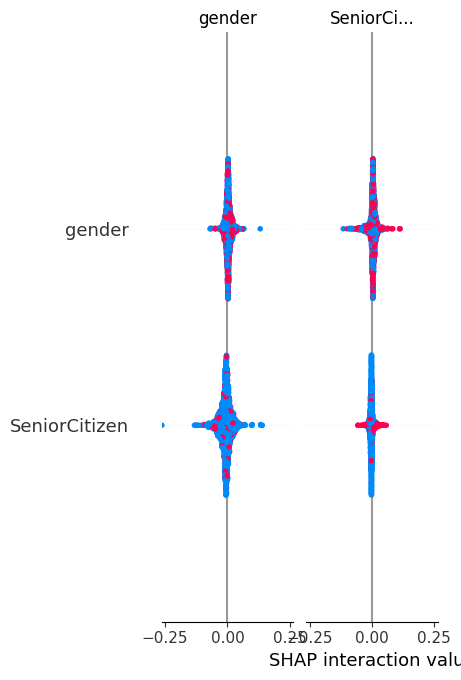

In [12]:
# Install SHAP
!pip install shap

# After installation, you can import it
import shap

# Use SHAP to explain model predictions
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Summary plot of feature importance
shap.summary_plot(shap_values, X_test, feature_names=X.columns)


Pipeline Model: (0.7849538679914834, 0.6, 0.5630026809651475, 0.5809128630705395)


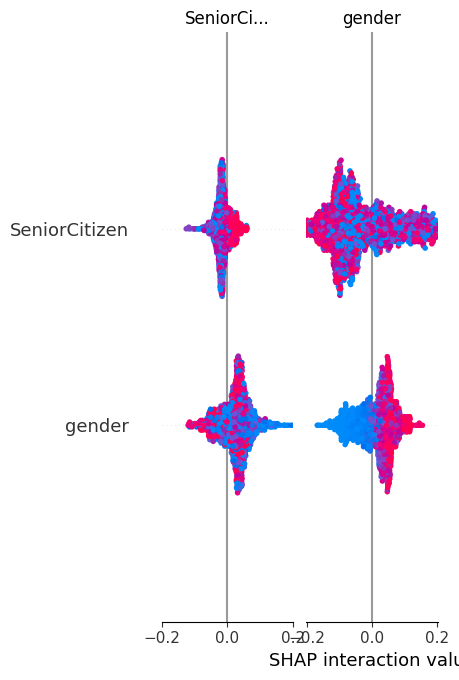

In [18]:
# Install necessary packages
!pip install shap imbalanced-learn

# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import shap
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE


# Handle missing values in 'TotalCharges' column (convert to numeric and fill NaNs)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'].fillna(data['TotalCharges'].mean(), inplace=True)



# Split features and target
X = data.drop('Churn', axis=1)
y = data['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define numerical and categorical transformers
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = X.columns.difference(numeric_features)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Use most_frequent for categorical
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])



# Define the full pipeline with SMOTE and RandomForest
pipeline = ImbPipeline(steps=[('preprocessor', preprocessor),
                              ('smote', SMOTE(random_state=42)),
                              ('classifier', RandomForestClassifier(random_state=42))])

# Train the pipeline
pipeline.fit(X_train, y_train)

# Evaluate the pipeline
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1

pipeline_results = evaluate_model(pipeline, X_test, y_test)
print(f"Pipeline Model: {pipeline_results}")

# SHAP for model interpretation
explainer = shap.TreeExplainer(pipeline.named_steps['classifier'])
shap_values = explainer.shap_values(preprocessor.transform(X_test))

# Summary plot of feature importance
shap.summary_plot(shap_values, preprocessor.transform(X_test), feature_names=X.columns)
